In [3]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import os


In [4]:
def combine_csv_files(folder_path):
    combined_df = pd.DataFrame()
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)
            combined_df = pd.concat([combined_df, df], ignore_index=True)
    return combined_df

In [5]:
# Step 1: Combine all CSV files from the benign folder
benign_folder = 'benign'
benign_df = combine_csv_files(benign_folder)

# Step 2: Combine all CSV files from the malicious folder
malicious_folder = 'malicious'
malicious_df = combine_csv_files(malicious_folder)

# Step 3: Combine the benign and malicious datasets
combined_df = pd.concat([benign_df, malicious_df], ignore_index=True)

# Step 4: Shuffle the combined dataset
shuffled_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 5: Save or print the shuffled dataframe
shuffled_df.to_csv('combined_shuffled_traffic.csv')
print(shuffled_df.head())

                                Flow ID      Src IP  Src Port         Dst IP  \
0    100.64.0.2-10.16.0.18-54432-3000-6  100.64.0.2     54432     10.16.0.18   
1    100.64.0.2-10.16.0.45-50116-1880-6  100.64.0.2     50116     10.16.0.45   
2    100.64.0.2-10.16.0.18-56618-3000-6  100.64.0.2     56618     10.16.0.18   
3  10.16.0.6-144.122.71.18-36186-6642-6   10.16.0.6     36186  144.122.71.18   
4    100.64.0.2-10.16.0.18-51778-3000-6  100.64.0.2     51778     10.16.0.18   

   Dst Port  Protocol                   Timestamp  Flow Duration  \
0      3000         6  2023-03-20 13:33:11.590899            552   
1      1880         6  2023-03-20 15:25:10.616403            294   
2      3000         6  2023-03-20 14:39:51.745413            486   
3      6642         6  2023-03-20 14:34:04.805173            960   
4      3000         6  2023-03-20 14:22:28.408067            821   

   Total Fwd Packet  Total Bwd packets  ...  Active Mean  Active Std  \
0                 6                  5

In [20]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    if df.columns[0] == 'Unnamed: 0':
        df.set_index(df.columns[0], inplace=True)
        df.reset_index(drop=True, inplace=True)
    print("Columns in the dataset:", df.columns.tolist())
    return df

def handle_zero_value_features(df, zero_threshold=0.9):
    # Identify the target column
    target_column = 'Label' if 'Label' in df.columns else 'Class'
    
    # Get all columns except the target column for zero analysis
    features = [col for col in df.columns if col != target_column]
    
    # Identify features with high percentage of zero values (excluding target column)
    high_zero_columns = [col for col in features if (df[col] == 0).mean() > zero_threshold]
    print(f"Found {len(high_zero_columns)} features with more than {zero_threshold*100}% zero values: {high_zero_columns}")

    # Ask user whether to remove these features
    if high_zero_columns:
        user_input = input(f"Do you want to remove features with more than {zero_threshold*100}% zero values? (y/n): ").lower()
        if user_input == 'y':
            df = df.drop(columns=high_zero_columns)
            all_zero_columns = df.drop(columns=[target_column]).columns[(df.drop(columns=[target_column]) == 0).all()].tolist()
            df = df.drop(columns=all_zero_columns)
            print(f"Removed {len(high_zero_columns)} features with high zero values.")
        else:
            print("Keeping features with high zero values.")

    return df

def handle_missing_values(df):
    target_column = 'Label' if 'Label' in df.columns else 'Class'
    features = [col for col in df.columns if col != target_column]
    
    numeric_columns = df[features].select_dtypes(include=[np.number]).columns
    categorical_columns = df[features].select_dtypes(exclude=[np.number]).columns
    
    for col in numeric_columns:
        if df[col].isnull().sum() / len(df) < 0.05:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            imputer = KNNImputer(n_neighbors=5)
            df[col] = imputer.fit_transform(df[[col]])
    
    for col in categorical_columns:
        df[col].fillna(df[col].mode()[0], inplace=True)
    
    return df

def handle_outliers(df):
    target_column = 'Label' if 'Label' in df.columns else 'Class'
    features = [col for col in df.columns if col != target_column]
    
    numeric_columns = df[features].select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower_bound, upper_bound)
    return df

def scale_features(df):
    target_column = 'Label' if 'Label' in df.columns else 'Class'
    features = [col for col in df.columns if col != target_column]
    
    numeric_columns = df[features].select_dtypes(include=[np.number]).columns
    scaler = RobustScaler()
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
    return df

def encode_categorical(df):
    target_column = 'Label' if 'Label' in df.columns else 'Class'
    features = [col for col in df.columns if col != target_column]
    
    le = LabelEncoder()
    categorical_columns = df[features].select_dtypes(include=['object']).columns
    for col in categorical_columns:
        df[col] = le.fit_transform(df[col])
    
    # Encode target column if it's categorical
    if df[target_column].dtype == 'object':
        df[target_column] = le.fit_transform(df[target_column])
    return df

def engineer_features(df):
    if 'Total Fwd Packets' in df.columns and 'Total Backward Packets' in df.columns:
        df['Fwd_Bwd_Packet_Ratio'] = df['Total Fwd Packets'] / df['Total Backward Packets'].replace(0, 1)
    if 'Fwd Packets Length Total' in df.columns and 'Bwd Packets Length Total' in df.columns:
        df['Fwd_Bwd_Byte_Ratio'] = df['Fwd Packets Length Total'] / df['Bwd Packets Length Total'].replace(0, 1)
    return df

def balance_classes(df, target_column):
    X = df.drop(columns=[target_column])
    y = df[target_column]
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return pd.concat([X_resampled, y_resampled], axis=1)

def preprocess_data(file_path):
    # df.drop_duplicates(inplace=True)
    df = load_data(file_path)
    df = handle_zero_value_features(df)
    df = handle_missing_values(df)  
    df = handle_outliers(df)
    df = scale_features(df)
    df = encode_categorical(df)
    df = engineer_features(df)
    
    target_column = 'Label' if 'Label' in df.columns else 'Class'
    if target_column in df.columns:
        df = balance_classes(df, target_column)
    else:
        print(f"Warning: Neither 'Label' nor 'Class' column found. Skipping class balancing.")
    
    return df



In [26]:

file_path = "combined_shuffled_traffic.csv"
preprocessed_df = preprocess_data(file_path)

print(preprocessed_df.head())
print("\nDataset shape:", preprocessed_df.shape)

Columns in the dataset: ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd RST Flags', 'Bwd RST Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Cou

C:\Users\user\AppData\Local\Temp\ipykernel_17764\1971413167.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_17764\1971413167.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

   Flow ID  Src IP  Src Port  Dst IP  Dst Port  Protocol  Timestamp  \
0    21037      11  0.487982       2  0.000000       0.0      16601   
1    32537      11  0.186417       4 -0.235195       0.0      53424   
2    21864      11  0.640721       2  0.000000       0.0      31875   
3     6865       7 -0.786892      15  0.764805       0.0      30265   
4    19858      11  0.302543       2  0.000000       0.0      27749   

   Flow Duration  Total Fwd Packet  Total Bwd packets  ...  \
0      -0.106299               0.0                0.0  ...   
1      -0.614173               0.0               -1.0  ...   
2      -0.236220              -1.0                0.0  ...   
3       0.696850               1.5                1.5  ...   
4       0.423228              -1.0                0.0  ...   

   Fwd Segment Size Avg  Bwd Segment Size Avg  Subflow Fwd Bytes  \
0              0.194573              0.090658           0.043478   
1             -0.015884             -0.015789           0.000000

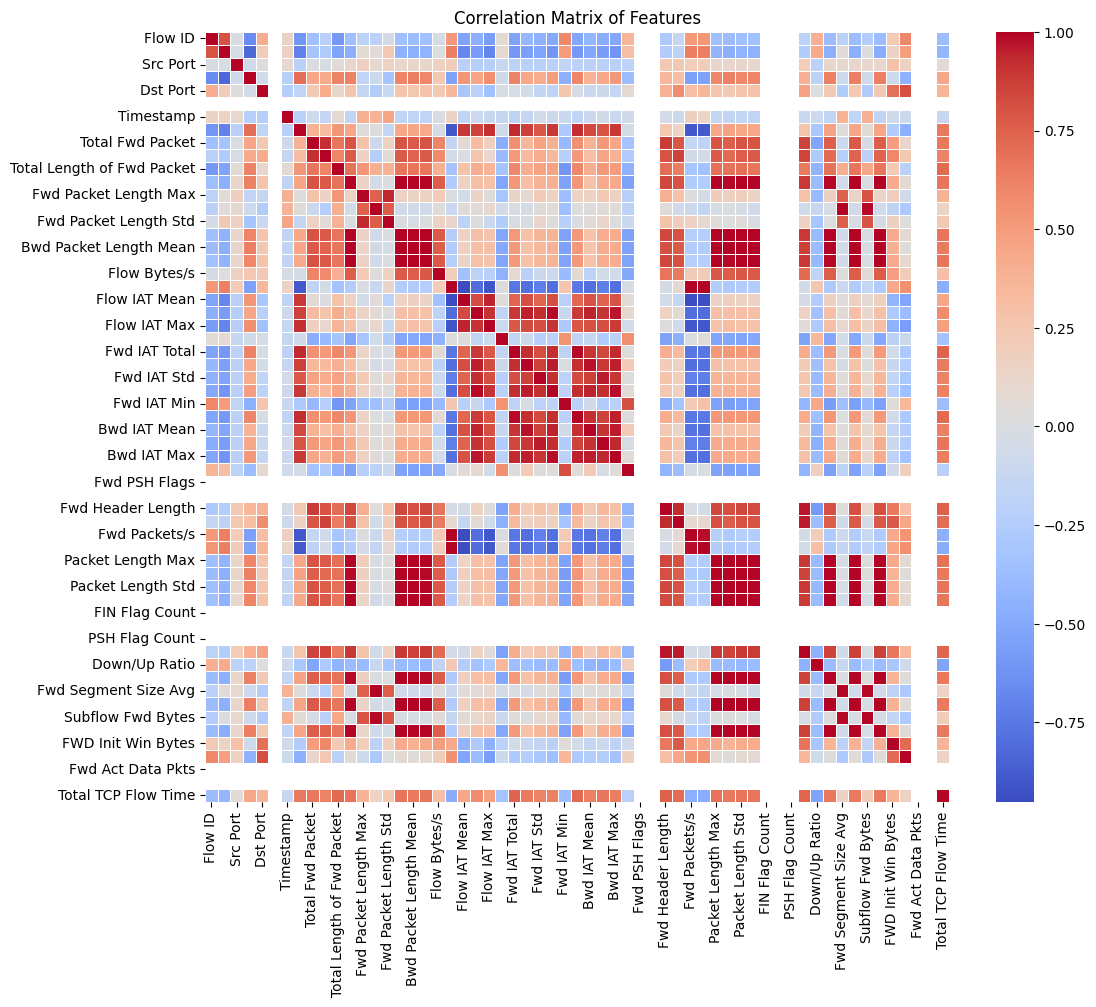

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = preprocessed_df.drop(columns=['Label']).corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

In [33]:
preprocessed_df.to_csv("preprocessed_ddos_dataset_1.csv", index=False)
print("Preprocessing completed. Saved as 'preprocessed_ddos_dataset.csv'")

Preprocessing completed. Saved as 'preprocessed_ddos_dataset.csv'
